**Задание:** Используя данные из архива data.zip попробуйте обучить модель SARIMA для всех трех наборов данных. Попробуйте подобрать наилучшие коэффициенты самостоятельно или использую auto_arima. Попробуйте добавить в модель дополнительную переменную “День недели”, оцените как изменилась точность модели после этого.

In [ ]:
#испорт модуля для автоподбора параметров
!pip install pmdarima

In [ ]:
!pip install ml_metrics

Импорт всех необходимыых библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import ml_metrics as metrics
import random

## Набор данных "milk_production"

Все файлы изначально были загружены на диск, который потом был подключен к колабу. Таким образом, через `read_csv` считывание всех файлов было произведено с диска

In [ ]:
milk_production = pd.read_csv('drive/MyDrive/milk_production.csv', index_col='Month', parse_dates=True)
milk_production.columns = ['_','pounds_per_cow']#переименование столбцов для лучшего понимания
milk_production.head()

,_,pounds_per_cow
Month,,
1962-01-01,0,589
1962-02-01,1,561
1962-03-01,2,640
1962-04-01,3,656
1962-05-01,4,727


В последующем столбец "_", который содержит в себе идентификаторы, мешает подбору параметров, поэтому дропаю его

In [ ]:
milk_production.drop('_', axis=1, inplace=True)

Вывод данных. Как видно из графика, данные содержат тренд и имеют явную сезонность

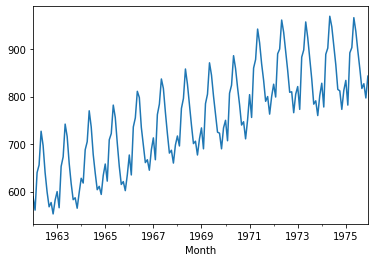

In [ ]:
milk_production.pounds_per_cow.plot()

Для детального просмотра временного ряда использую метод `seasonal_decompose`. Исходя из второго графика, представляющего линию тренда, можно сказать, что тренд не линейный, он имеет как падения, так и рост, а в конце почти выравнивается. Сезонность же одинаковая (третий график), скорее всего пик находится в летнее времена года. При этом сезонность не имеет тренда

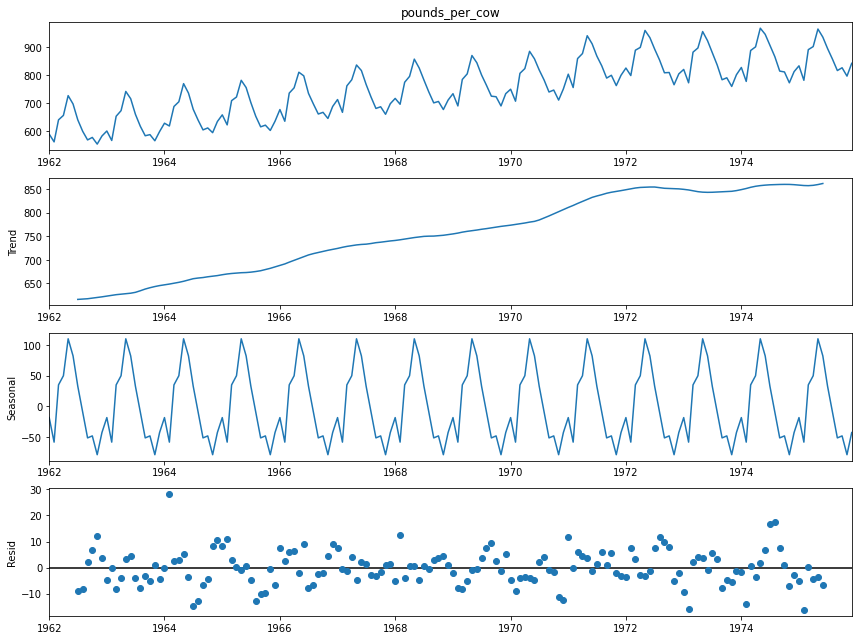

In [ ]:
decomp_milk = seasonal_decompose(milk_production['pounds_per_cow'], period=12)
fig = decomp_milk.plot()
fig.set_size_inches((12, 9))
plt.tight_layout()

Избавиться от тренда и сезонности можно с помощью метода `diff`

In [ ]:
milk_prod = pd.DataFrame()

In [ ]:
milk_prod['diff'] = milk_production.pounds_per_cow.diff().diff(12).dropna()

Можно сказать, что ряд стационарен и его можно рассматривать для подбора параметров и построения модели

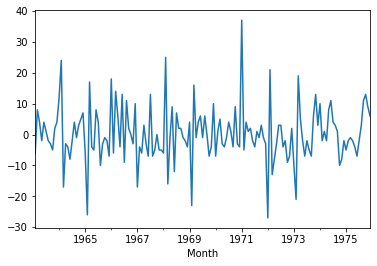

In [ ]:
milk_prod['diff'].plot()#представление данных без тренда и сезонности

Для выполнения второй части задания сразу инициализирую столбец с днем недели с помощью класса `DatetimeIndex`

In [ ]:
milk_prod['weekday'] = pd.DatetimeIndex(milk_prod.index).to_series().dt.day_of_week

In [ ]:
milk_prod.head()

,diff,weekday
Month,,
1963-02-01,-6.0,4
1963-03-01,8.0,4
1963-04-01,4.0,0
1963-05-01,-2.0,2
1963-06-01,4.0,5


Вывод автокорреляционной и частично автокорелляционной функций для того, чтобы визуально иметь представление, какое количество q и p необходимо. На графиках видно, что покказатель `q=1`, а `p=3`

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


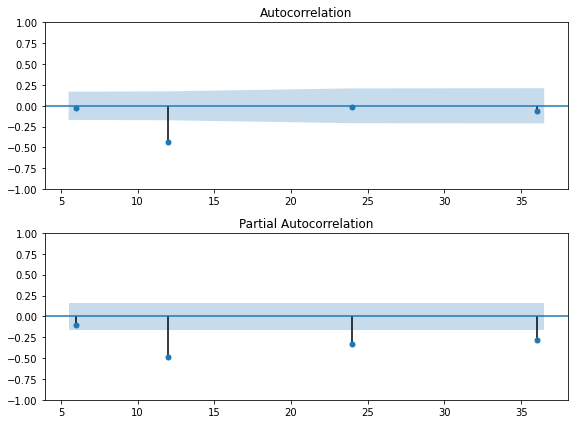

In [ ]:
lags = [6, 12, 24, 36]

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

#Автокорелляционная функция для q
plot_acf(milk_prod['diff'], lags=lags, zero=False, ax=ax1);

#Частично автокорелляционная функция для p
plot_pacf(milk_prod['diff'], lags=lags, zero=False, ax=ax2);
plt.tight_layout();

С помощью цикла и количества лагов от 6 до 36, было установлено, что с 36 лагами получается минимальный результат BIC и AIC. В свою очередь перебор параметров происходил с учтом того, что по умолчанию `max_q=5`, `max_Q=2`, `max_P=2` и данных параметров в полне достаточно, исходя из графиков автокорелляционной и частично автокорялляционной функциях.

In [ ]:
lags = [6, 12, 24, 36]

In [ ]:
for i in lags:
  model1 = pm.auto_arima(milk_prod['diff'],
                        seasonal=True, m=i,
                        d=1, D=1,
                        max_p=3,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True)
  print(model1.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[6]             : AIC=inf, Time=1.04 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=1314.227, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=1236.753, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=inf, Time=0.30 sec
 ARIMA(1,1,0)(0,1,0)[6]             : AIC=1245.637, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[6]             : AIC=1187.684, Time=0.20 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=inf, Time=0.78 sec
 ARIMA(1,1,0)(1,1,1)[6]             : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(2,1,0)[6]             : AIC=1255.826, Time=0.14 sec
 ARIMA(2,1,0)(2,1,0)[6]             : AIC=1151.161, Time=0.52 sec
 ARIMA(2,1,0)(1,1,0)[6]             : AIC=1203.104, Time=0.26 sec
 ARIMA(2,1,0)(2,1,1)[6]             : AIC=inf, Time=1.60 sec
 ARIMA(2,1,0)(1,1,1)[6]             : AIC=inf, Time=0.95 sec
 ARIMA(3,1,0)(2,1,0)[6]             : AIC=1145.980, Time=0.38 sec
 ARIMA(3,1,0)(1,1,0)[6]             : AIC=1199.631, Time=0.34 s

Таким образом, как и на графике, параметр p=3, а вот параметр q=0. При этом `AIC=952.352`, `BIC=968.976`. Лучшие параметры: (3, 1, 0) и (2, 1, 0, 36). Можно переходить к обучению модели

In [ ]:
model = SARIMAX(milk_prod['diff'], order=(3, 1, 0), seasonal_order=(2, 1, 0, 36))
results = model.fit()
results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               diff   No. Observations:                  155
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 36)   Log Likelihood                -470.176
Date:                            Tue, 11 Oct 2022   AIC                            952.352
Time:                                    11:04:47   BIC                            968.976
Sample:                                02-01-1963   HQIC                           959.102
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9649      0.064    -15.066      0.000      -1.090      -0.839
ar.L2         -0.6405      0.119     -5.398      0.000      -0.873      -0.408
ar.L3         -0.2054      0.104     -1.982      0.047      -0.408      -0.002
ar.S.L36      -0.6386      0.115     -5.550      0.000      -0.864      -0.413
ar.S.L72      -0.2986      0.111     -2.690      0.007      -0.516      -0.081
sigma2       145.6237     15.734      9.255      0.000     114.786     176.462
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                58.63
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                             0.78
Prob(H) (two-sided):                  0.18   Kurtosis:                         6.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Чтобы понять правильность прогноза модели, делаю предсказание на следующий год

In [ ]:
pred_1 = results.fittedvalues #предсказание моделью переданных в обучение дат

In [ ]:
pred = results.forecast(steps=12)

Отображение результатов прогноза вместе с изначальными данными. Как видно, начало модель предсказала правильно, однако в середине прогноз не совпал, ближе к концу он немного выровнялся, но всё также не совпал. Зеленый участок графика отображает предсказание на следующий год

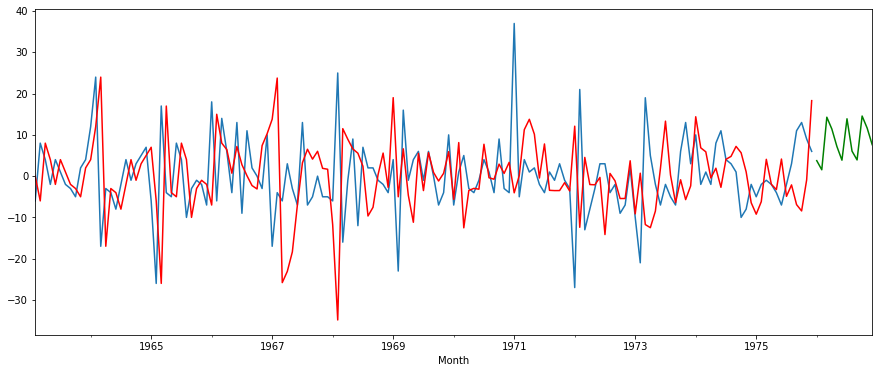

In [ ]:
milk_prod["diff"].plot(figsize=(15,6))
pred.plot(style='g')
pred_1.plot(style='r')

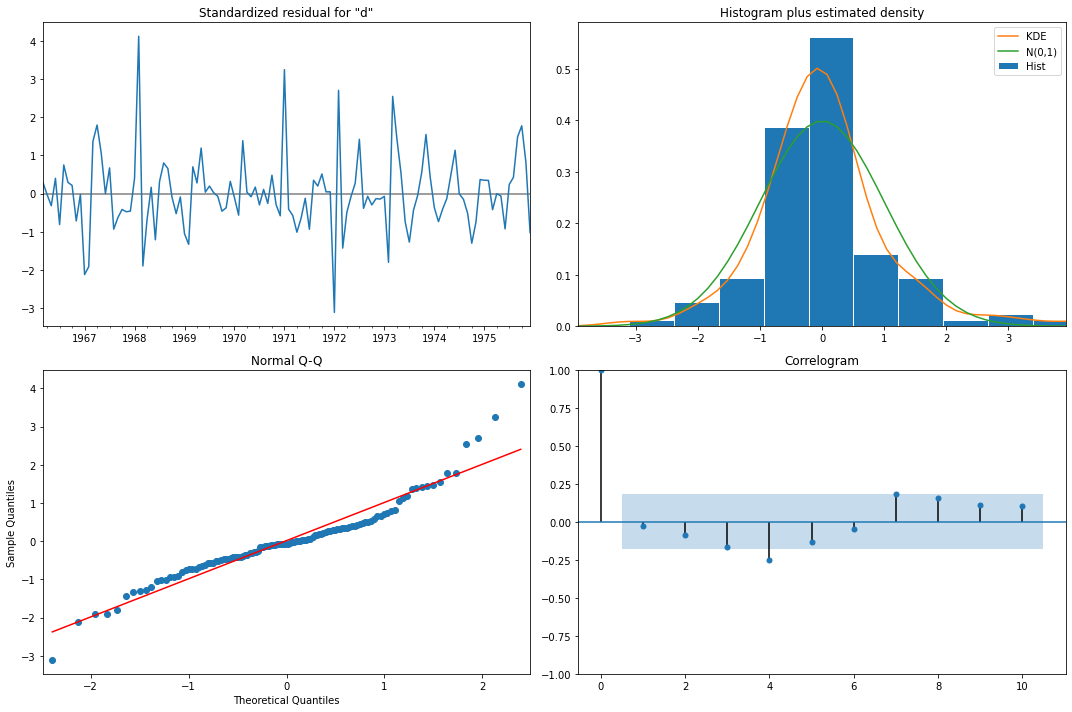

In [ ]:
results.plot_diagnostics(figsize=(15, 10));
plt.tight_layout();

In [ ]:
print('Средняя абсолютная ошибка: ', metrics.mae(milk_prod["diff"], pred_1))
print('Среднеквадратичное отклонение: ', metrics.rmse(milk_prod["diff"], pred_1))

Средняя абсолютная ошибка:  9.126701312754868
Среднеквадратичное отклонение:  13.347783634344118


Дальше необходимо проверить точность модели с использованием дополнительной переменной 'День недели' - 'weekday'. Добавить переменную можно с помощью параметра `exog`

In [ ]:
model = SARIMAX(milk_prod['diff'], order=(3, 1, 0), seasonal_order=(2, 1, 0, 36), exog=milk_prod['weekday'], enforce_invertibility=False)
results = model.fit()
results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               diff   No. Observations:                  155
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 36)   Log Likelihood                -469.879
Date:                            Tue, 11 Oct 2022   AIC                            953.758
Time:                                    11:33:48   BIC                            973.152
Sample:                                02-01-1963   HQIC                           961.632
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
weekday       -0.3468      0.554     -0.626      0.531      -1.432       0.739
ar.L1         -0.9644      0.070    -13.693      0.000      -1.102      -0.826
ar.L2         -0.6381      0.122     -5.242      0.000      -0.877      -0.400
ar.L3         -0.2090      0.104     -2.011      0.044      -0.413      -0.005
ar.S.L36      -0.6330      0.114     -5.565      0.000      -0.856      -0.410
ar.S.L72      -0.2896      0.113     -2.569      0.010      -0.511      -0.069
sigma2       145.4630     15.929      9.132      0.000     114.243     176.683
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                68.08
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             0.86
Prob(H) (two-sided):                  0.16   Kurtosis:                         6.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#добавление дня недели для предсказания
pred_weekday = pd.DatetimeIndex(pred.index).to_series().dt.day_of_week

In [ ]:
#предсказание для имеющихся в выборке дат
pred_df = results.fittedvalues

In [ ]:
#предсказание для следующего года
pred_res = results.forecast(steps=12, exog=pred_weekday)

Отрисовка графика. В целом, график не отличается, только в определенных местах, как например,между 1974 и 1975 годом

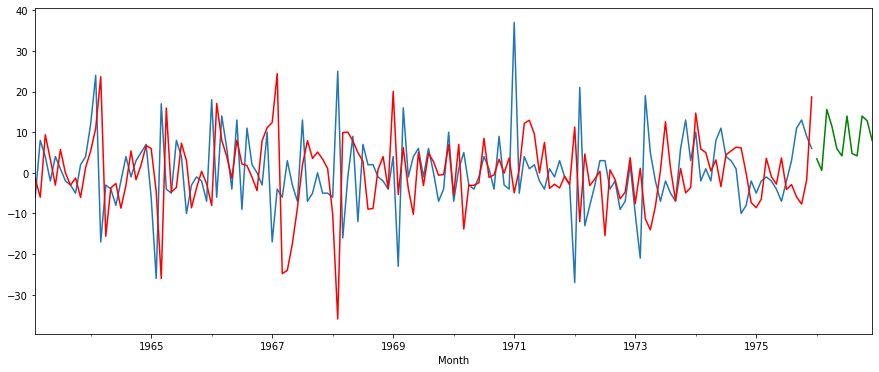

In [ ]:
milk_prod['diff'].plot(figsize=(15,6))
pred_res.plot(style='g')
pred_df.plot(style='r')

Результаты по AIC и BIC с применением дополнительной переменной хуже, чем без её применения. А в случае со средней ошибкой и отклонением результат лучше.
Средняя абсолютная ошибка без новой переменной - 9.126701312754868, среднеквадратиное отклонение без новой переменной - 13.347783634344118

In [ ]:
print('Средняя абсолютная ошибка: ', metrics.mae(milk_prod["diff"], pred_df))
print('Среднеквадратичное отклонение: ', metrics.rmse(milk_prod["diff"], pred_df))

Средняя абсолютная ошибка:  9.10168418989958
Среднеквадратичное отклонение:  13.344994719172718


## Набор данных "AirPassengers"

Загружаю данные второй выборки и также переименовываю столбец для удобства

In [ ]:
air_passengers = pd.read_csv('drive/MyDrive/AirPassengers.csv', index_col='Month', parse_dates=True)
air_passengers.columns = ['passengers']#переименование столбцов для лучшего понимания
air_passengers.head()

,passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


По графику видно, что ряд имеет тренд, сезонность и тренд в сезонности

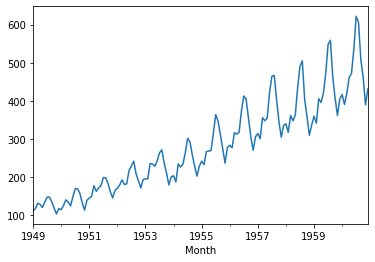

In [ ]:
air_passengers.passengers.plot()

Метод декомпозиции подтверждает наблюдения. Тренд не линейный, как и в предыдущем примере. Сезонность имеет пик летом, что очевидно, т.к. это самое популярное время для полетов в разные места.

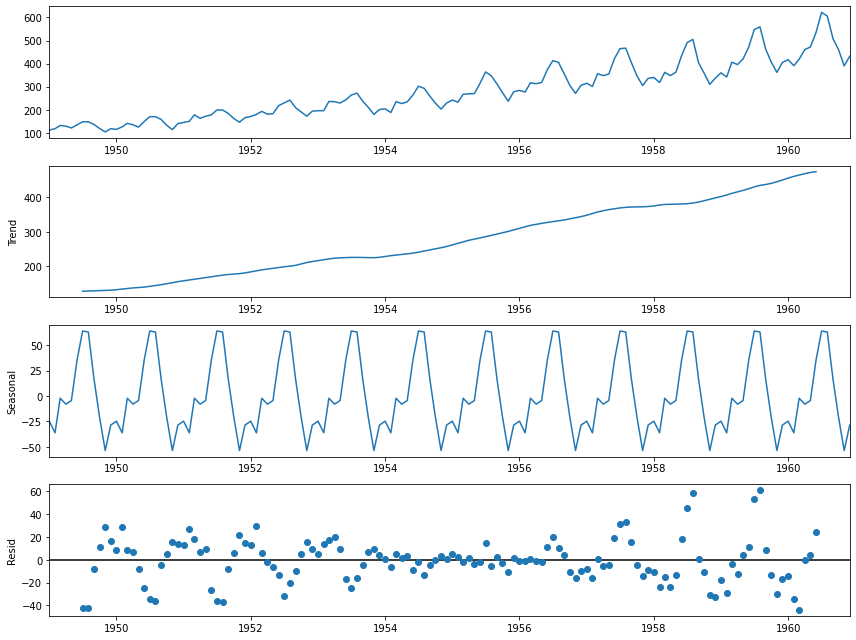

In [ ]:
decomp_air = seasonal_decompose(air_passengers, period=12)
fig = decomp_air.plot()
fig.set_size_inches((12, 9))
plt.tight_layout()

In [ ]:
air_pass = pd.DataFrame()

In [ ]:
air_pass['diff'] = air_passengers.diff().diff(12).diff().dropna()#избавляемся от тренда, сезонности и тренда в сезонности

Каждый diff был проверен на стационарность с помощью функции `adfuller`

In [ ]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(air_pass['diff'])
print('adf: ', dftest[0])
print('p-value: ', dftest[1])
print('Critical values: ', dftest[4])
if dftest[0]> dftest[4]['5%']:
  print('есть единичные корни, ряд не стационарен')
else:
  print('единичных корней нет, ряд стационарен')

adf:  -8.097600237954426
p-value:  1.3261063698283317e-12
Critical values:  {'1%': -3.4851223522012855, '5%': -2.88553750045158, '10%': -2.5795685622144586}
единичных корней нет, ряд стационарен


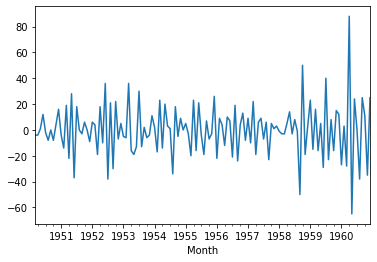

In [ ]:
air_pass['diff'].plot()#представление данных без тренда и сезонности

Так же, добавляю новый столбец дня недели для того, чтобы обучить модель с помощью дополнительной переменной

In [ ]:
air_pass['weekday'] = pd.DatetimeIndex(air_pass.index).to_series().dt.day_of_week

In [ ]:
air_pass.head()

,diff,weekday
Month,,
1950-03-01,-4.0,2
1950-04-01,-4.0,5
1950-05-01,1.0,0
1950-06-01,12.0,3
1950-07-01,-2.0,5


Далее проверяю графики ACF и PACF для приблизительного нахождения параметров p и q. В данной случае `q=0`, `p=2`

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


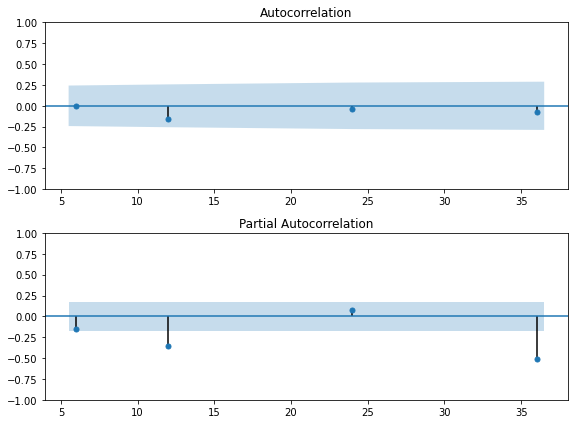

In [ ]:
lags = [6, 12, 24, 36]

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

#Автокорелляционная функция для q
plot_acf(air_pass['diff'], lags=lags, zero=False, ax=ax1);

#Частично автокорелляционная функция для p
plot_pacf(air_pass['diff'], lags=lags, zero=False, ax=ax2);
plt.tight_layout();

С помощью цикла перебираю лаги

In [ ]:
for i in lags:
  model1 = pm.auto_arima(air_pass['diff'],
                        seasonal=True, m=i,
                        d=1, D=2,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True)
  print(model1.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,2,1)[6]             : AIC=inf, Time=1.38 sec
 ARIMA(0,1,0)(0,2,0)[6]             : AIC=1383.998, Time=0.04 sec
 ARIMA(1,1,0)(1,2,0)[6]             : AIC=1215.913, Time=0.13 sec
 ARIMA(0,1,1)(0,2,1)[6]             : AIC=inf, Time=0.31 sec
 ARIMA(1,1,0)(0,2,0)[6]             : AIC=1264.422, Time=0.07 sec
 ARIMA(1,1,0)(2,2,0)[6]             : AIC=1163.188, Time=0.29 sec
 ARIMA(1,1,0)(2,2,1)[6]             : AIC=inf, Time=0.71 sec
 ARIMA(1,1,0)(1,2,1)[6]             : AIC=inf, Time=0.72 sec
 ARIMA(0,1,0)(2,2,0)[6]             : AIC=1286.693, Time=0.19 sec
 ARIMA(2,1,0)(2,2,0)[6]             : AIC=1138.312, Time=0.49 sec
 ARIMA(2,1,0)(1,2,0)[6]             : AIC=1180.288, Time=0.17 sec
 ARIMA(2,1,0)(2,2,1)[6]             : AIC=inf, Time=0.76 sec
 ARIMA(2,1,0)(1,2,1)[6]             : AIC=inf, Time=0.40 sec
 ARIMA(3,1,0)(2,2,0)[6]             : AIC=1129.523, Time=0.72 sec
 ARIMA(3,1,0)(1,2,0)[6]             : AIC=1174.456, Time=0.28 s

Таким образом, наилучшие показатели `AIC=552.085`, `BIC=566.386` при этом `p=2`, `q=2`, `P=1`, `Q=1`, `lags=36`

Обучение модели на выбранных показателях

In [ ]:
model1 = SARIMAX(air_pass['diff'], order=(2, 1, 2), seasonal_order=(1, 2, 1, 36))
results = model1.fit()
results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likeliho

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 diff   No. Observations:                  130
Model:             SARIMAX(2, 1, 2)x(1, 2, [1], 36)   Log Likelihood                -269.042
Date:                              Tue, 11 Oct 2022   AIC                            552.085
Time:                                      11:49:59   BIC                            566.386
Sample:                                  03-01-1950   HQIC                           557.643
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3534      0.194     -1.825      0.068      -0.733       0.026
ar.L2         -0.0699      0.194     -0.360      0.719      -0.450       0.311
ma.L1         -1.9314      8.270     -0.234      0.815     -18.140      14.277
ma.L2          0.9324      7.720      0.121      0.904     -14.198      16.063
ar.S.L36      -0.9718     38.635     -0.025      0.980     -76.696      74.752
ma.S.L36       0.6780    200.824      0.003      0.997    -392.931     394.287
sigma2       304.6220   4.35e+04      0.007      0.994    -8.5e+04    8.56e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.27
Prob(Q):                              0.74   Prob(JB):                         0.87
Heteroskedasticity (H):               1.17   Skew:                            -0.15
Prob(H) (two-sided):                  0.73   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Модель обучилась. При этом некоторые показатели оказались статистически незначимы (`ma.S.L36`, `sigma2`). Дальше необходимо сделать предсказание на следующий год

In [ ]:
pred_df = results.fittedvalues #предсказание моделью переданных в обучение дат

In [ ]:
pred_res = results.forecast(steps=12)#запись предсказанных значений в массив

На графике видно, что данные визуально предсказаны верно, т.к. имеют схожую структуру. Однако в середине графика явно предсказание сбилось и давалослишком большие результаты, похожие на выбросы. В конце графика зелёным обозначен новый отрезок

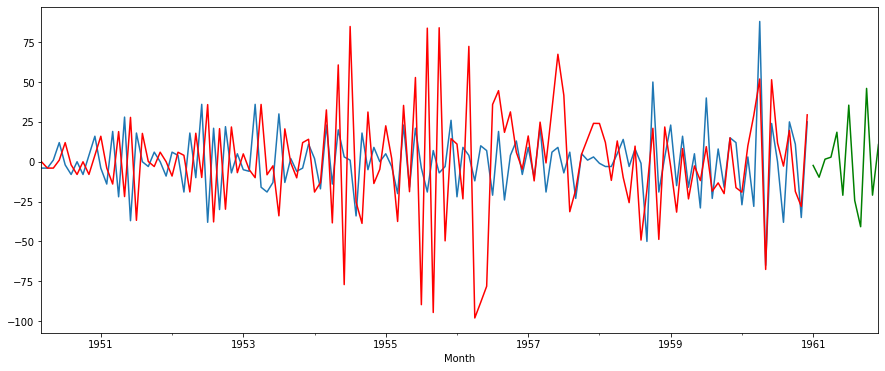

In [ ]:
air_pass['diff'].plot(figsize=(15,6))
pred_res.plot(style='g')
pred_df.plot(style='r')

In [ ]:
print('Средняя абсолютная ошибка: ', metrics.mae(air_pass['diff'], pred_df))
print('Среднеквадратичное отклонение: ', metrics.rmse(air_pass['diff'], pred_df))

Средняя абсолютная ошибка:  26.69903978425351
Среднеквадратичное отклонение:  36.43970577189494


Обучение модели с использованием новой переменной дня недели

In [ ]:
model1 = SARIMAX(air_pass['diff'], order=(2, 1, 2), seasonal_order=(1, 2, 1, 36), exog=air_pass['weekday'])
results = model1.fit()
results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likeliho

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 diff   No. Observations:                  130
Model:             SARIMAX(2, 1, 2)x(1, 2, [1], 36)   Log Likelihood                -270.565
Date:                              Tue, 11 Oct 2022   AIC                            557.130
Time:                                      11:53:59   BIC                            573.475
Sample:                                  03-01-1950   HQIC                           563.482
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
weekday       -0.2817      0.574     -0.491      0.623      -1.406       0.843
ar.L1         -0.3321      0.195     -1.700      0.089      -0.715       0.051
ar.L2         -0.1111      0.165     -0.674      0.500      -0.434       0.212
ma.L1         -1.8242      2.152     -0.848      0.397      -6.041       2.393
ma.L2          0.9965      2.344      0.425      0.671      -3.598       5.591
ar.S.L36      -0.8301     43.835     -0.019      0.985     -86.744      85.084
ma.S.L36       0.2676     95.174      0.003      0.998    -186.270     186.805
sigma2       429.2535   1.09e+04      0.040      0.968   -2.09e+04    2.17e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 0.55
Prob(Q):                              0.71   Prob(JB):                         0.76
Heteroskedasticity (H):               1.19   Skew:                            -0.17
Prob(H) (two-sided):                  0.70   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
pred_df = results.fittedvalues #предсказание моделью переданных в обучение дат

In [ ]:
#добавление дня недели для предсказания
pred_weekday = pd.DatetimeIndex(pred_res.index).to_series().dt.day_of_week

In [ ]:
pred_res = results.forecast(steps=12, exog=pred_weekday)#запись предсказанных значений в массив

Отрисовка графика. По графику видно, что модель на несколько пунктов завышает итоговые значения.

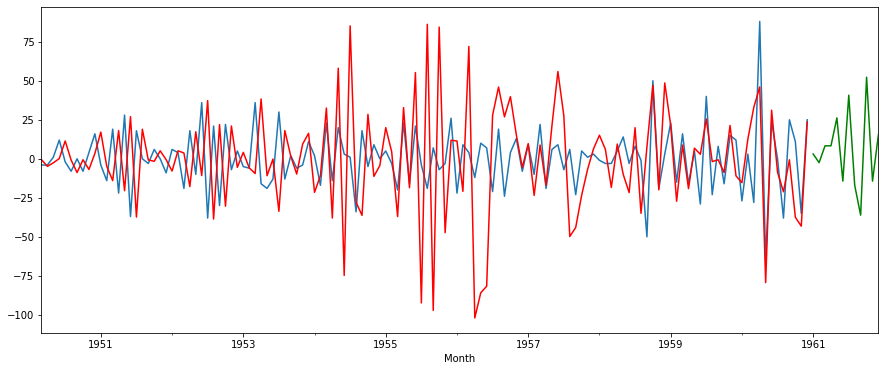

In [ ]:
air_pass['diff'].plot(figsize=(15,6))
pred_res.plot(style='g')
pred_df.plot(style='r')

AIC и BIC в данной модели больше на несколько сотых, средняя абсолютная ошибка меньше, чем ошибка без новой переменной, а отклонение наоборот - больше.

Средняя абсолютная ошибка без новой переменной - 26.69903978425351
Среднеквадратичное отклонение без новой переменной - 36.43970577189494

In [ ]:
print('Средняя абсолютная ошибка: ', metrics.mae(air_pass['diff'], pred_df))
print('Среднеквадратичное отклонение: ', metrics.rmse(air_pass['diff'], pred_df))

Средняя абсолютная ошибка:  26.394342217999068
Среднеквадратичное отклонение:  36.686743079111295


## Набор данных "aus_employment"

Последний набор данных. В данном наборе нет необходимости переименовыать столбцы

In [ ]:
aus_employment = pd.read_csv('drive/MyDrive/aus_employment.csv', index_col='date', parse_dates=True)
aus_employment.head()

,people_employed
date,
1978-01-01,5985.7
1978-02-01,6040.6
1978-03-01,6054.2
1978-04-01,6038.3
1978-05-01,6031.3


На графике видно, что ряд имеет тренд, причем явно не линейный со спадом, а также видна сезонность, но не так сильно, как на предыдущих данных

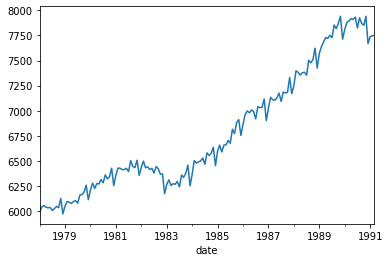

In [ ]:
aus_employment.people_employed.plot()

Декомпазиция ряда подтверждает гипотезу о тренде и сезонности. Период сезонности также годовой

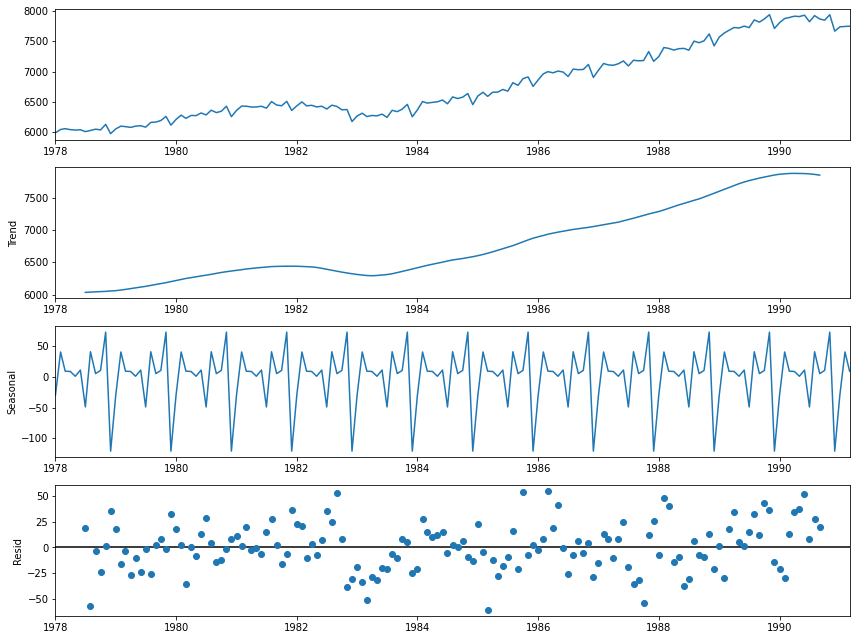

In [ ]:
decomp_aus = seasonal_decompose(aus_employment, period=12)
fig = decomp_aus.plot()
fig.set_size_inches((12, 9))
plt.tight_layout()

In [ ]:
aus_empl = pd.DataFrame()

In [ ]:
aus_empl['diff'] = aus_employment.diff().diff(12).dropna()#избавляемся от тренда и сезонности

Проверяю на стационарность

In [ ]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(aus_empl['diff'])
print('adf: ', dftest[0])
print('p-value: ', dftest[1])
print('Critical values: ', dftest[4])
if dftest[0]> dftest[4]['5%']:
  print('есть единичные корни, ряд не стационарен')
else:
  print('единичных корней нет, ряд стационарен')

adf:  -4.180913122810119
p-value:  0.0007096709681474455
Critical values:  {'1%': -3.480118600110386, '5%': -2.8833618426136196, '10%': -2.578407034974382}
единичных корней нет, ряд стационарен


Вывод графика по отредактированным данным

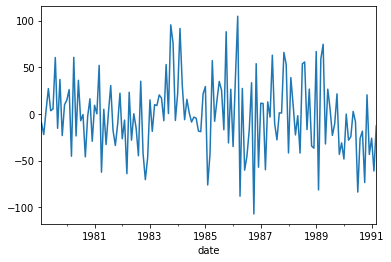

In [ ]:
aus_empl['diff'].plot()

In [ ]:
#добавление дня недели к каждой дате
aus_empl['weekday'] = pd.DatetimeIndex(aus_empl.index).to_series().dt.day_of_week

In [ ]:
aus_empl.head()

,diff,weekday
date,,
1979-02-01,-9.4,3
1979-03-01,-22.1,3
1979-04-01,3.8,6
1979-05-01,27.1,1
1979-06-01,3.4,4


При подборе параметров сначала также воспользуюсь функциями автокорелляции и частичной автокорелляции. На графиках явно видно, что p имеет два значения, а q - одно значение. `q=1`, `p=2`

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


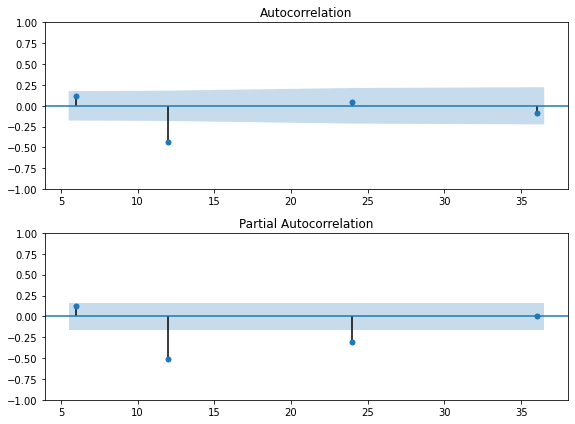

In [ ]:
lags = [6, 12, 24, 36]

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

#Автокорелляционная функция для q
plot_acf(aus_empl['diff'], lags=lags, zero=False, ax=ax1);

#Частично автокорелляционная функция для p
plot_pacf(aus_empl['diff'], lags=lags, zero=False, ax=ax2);
plt.tight_layout();

С помощью auto_arima перебираю переменные. `AIC = 1162.937`, `BIC = 1176.393`

In [ ]:

model1 = pm.auto_arima(aus_empl['diff'],
                      seasonal=True, m=36,
                      d=1, D=1,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True)
print(model1.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[36]             : AIC=inf, Time=13.47 sec
 ARIMA(0,1,0)(0,1,0)[36]             : AIC=1296.479, Time=0.15 sec
 ARIMA(1,1,0)(1,1,0)[36]             : AIC=1212.495, Time=1.59 sec
 ARIMA(0,1,1)(0,1,1)[36]             : AIC=inf, Time=6.04 sec
 ARIMA(1,1,0)(0,1,0)[36]             : AIC=1233.892, Time=0.25 sec
 ARIMA(1,1,0)(2,1,0)[36]             : AIC=inf, Time=10.05 sec
 ARIMA(1,1,0)(1,1,1)[36]             : AIC=inf, Time=7.10 sec
 ARIMA(1,1,0)(0,1,1)[36]             : AIC=inf, Time=4.42 sec
 ARIMA(1,1,0)(2,1,1)[36]             : AIC=inf, Time=21.97 sec
 ARIMA(0,1,0)(1,1,0)[36]             : AIC=1272.080, Time=1.29 sec
 ARIMA(2,1,0)(1,1,0)[36]             : AIC=1184.538, Time=2.29 sec
 ARIMA(2,1,0)(0,1,0)[36]             : AIC=1208.567, Time=0.49 sec
 ARIMA(2,1,0)(2,1,0)[36]             : AIC=1179.977, Time=7.36 sec
 ARIMA(2,1,0)(2,1,1)[36]             : AIC=inf, Time=30.26 sec
 ARIMA(2,1,0)(1,1,1)[36]             : AIC=inf, Ti

Передаю в модель подобранные значения переменных: `(0, 1, 2) (2, 2, 0, 36)`. Итоговый `AIC = 863.396`, `BIC = 874.849`

In [ ]:
model1 = SARIMAX(aus_empl['diff'], order=(0, 1, 2), seasonal_order=(2, 2, 0, 36))
results = model1.fit()
results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                diff   No. Observations:                  146
Model:             SARIMAX(0, 1, 2)x(2, 2, [], 36)   Log Likelihood                -426.698
Date:                             Tue, 11 Oct 2022   AIC                            863.396
Time:                                     12:05:20   BIC                            874.849
Sample:                                 02-01-1979   HQIC                           867.960
                                      - 03-01-1991                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.2207      0.109    -11.174      0.000      -1.435      -1.007
ma.L2          0.5414      0.101      5.368      0.000       0.344       0.739
ar.S.L36      -1.1934      0.420     -2.840      0.005      -2.017      -0.370
ar.S.L72      -0.7721      0.552     -1.398      0.162      -1.855       0.311
sigma2      2156.9638   4501.815      0.479      0.632   -6666.432     1.1e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.83   Prob(JB):                         0.95
Heteroskedasticity (H):               1.51   Skew:                            -0.06
Prob(H) (two-sided):                  0.32   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
pred_df = results.fittedvalues #предсказание моделью переданных в обучение дат

In [ ]:
pred_res = results.forecast(steps=12)#предсказание на следующий год

Можно сравнить данные, которые получились с теми, которые уже были изначально. На данных, которые уже были, начало предсказания почти совпало, однако с 1982 год начались сбои и предсказание явно ухудшилось, давая большие выбросы. В конце можно заметить зеленый отрезок, который предсказывает следующий год

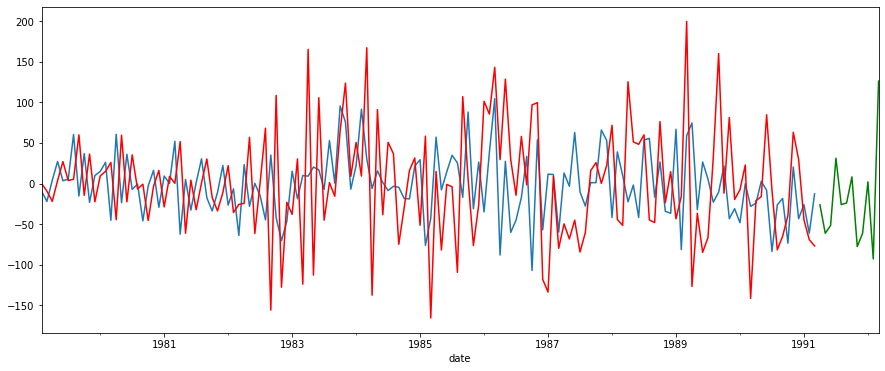

In [ ]:
aus_empl['diff'].plot(figsize=(15,6))
pred_res.plot(style='g')
pred_df.plot(style='r')

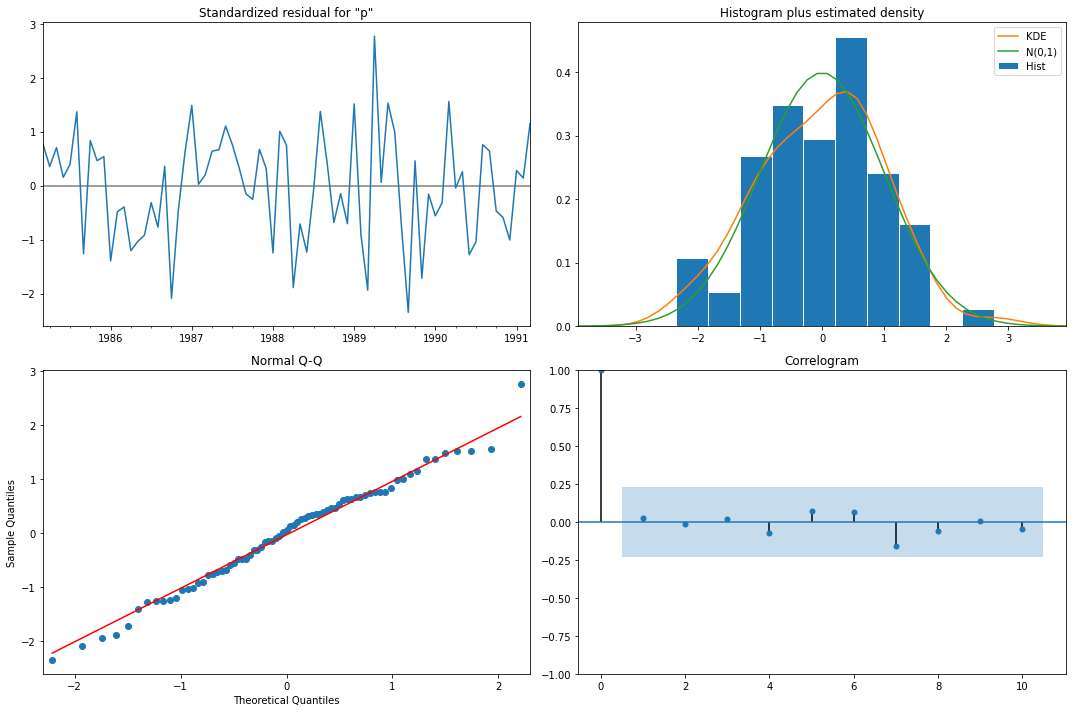

In [ ]:
results.plot_diagnostics(figsize=(15, 10));
plt.tight_layout();

In [ ]:
print('Средняя абсолютная ошибка: ', metrics.mae(aus_empl['diff'], pred_df))
print('Среднеквадратичное отклонение: ', metrics.rmse(aus_empl['diff'], pred_df))

Средняя абсолютная ошибка:  61.56661980597161
Среднеквадратичное отклонение:  75.87365415407659


Обучение с использованием новой переменной. Это первая модель и выборка, результаты при обучении с новой переменной которой лучше, чем без этой переменной. AIC стал меньше, а BIC - больше.

AIC без переменной = 874.849,
BIC без переменной = 867.960

In [ ]:
model1 = SARIMAX(aus_empl['diff'], order=(0, 1, 2), seasonal_order=(2, 2, 0, 36), exog=aus_empl['weekday'])
results = model1.fit()
results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                diff   No. Observations:                  146
Model:             SARIMAX(0, 1, 2)x(2, 2, [], 36)   Log Likelihood                -426.205
Date:                             Tue, 11 Oct 2022   AIC                            864.410
Time:                                     12:11:24   BIC                            878.152
Sample:                                 02-01-1979   HQIC                           869.886
                                      - 03-01-1991                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
weekday       -2.0674      2.641     -0.783      0.434      -7.244       3.109
ma.L1         -1.2255      0.109    -11.201      0.000      -1.440      -1.011
ma.L2          0.5634      0.110      5.119      0.000       0.348       0.779
ar.S.L36      -1.1658      0.491     -2.374      0.018      -2.128      -0.203
ar.S.L72      -0.7238      0.652     -1.109      0.267      -2.003       0.555
sigma2      2485.8380   4890.778      0.508      0.611   -7099.912    1.21e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.89   Prob(JB):                         0.95
Heteroskedasticity (H):               1.55   Skew:                            -0.08
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
pred_df = results.fittedvalues #предсказание моделью переданных в обучение дат

In [ ]:
pred_weekday = pd.DatetimeIndex(pred_res.index).to_series().dt.day_of_week

In [ ]:
pred_res = results.forecast(steps=12, exog=pred_weekday)#предсказание на следующий год

График не сильно отличается от графика модели без переменной

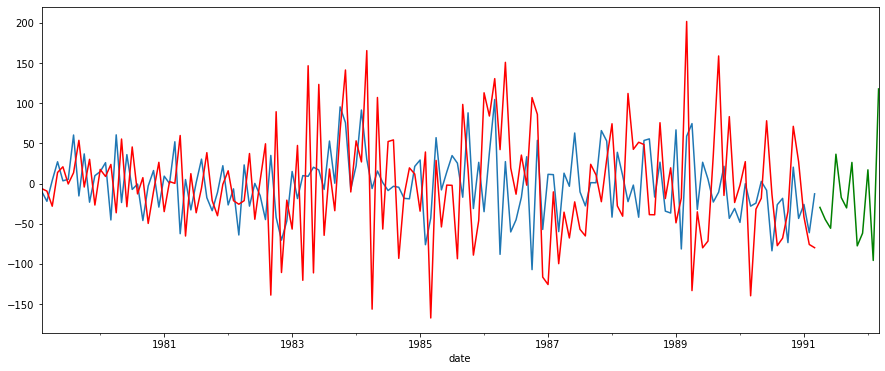

In [ ]:
aus_empl['diff'].plot(figsize=(15,6))
pred_res.plot(style='g')
pred_df.plot(style='r')

Реззультаты ошибки и отклонения в этом случае стали меньше. То есть, учитывая показатели AIC и BIC, для данной выборки и моедли день недели внес полезность и немного увеличил точность предсказания

Средняя абсолютная ошибка - 61.56661980597161
Среднеквадратичное отклонение - 75.87365415407659

In [ ]:
print('Средняя абсолютная ошибка: ', metrics.mae(aus_empl['diff'], pred_df))
print('Среднеквадратичное отклонение: ', metrics.rmse(aus_empl['diff'], pred_df))

Средняя абсолютная ошибка:  60.892575106350705
Среднеквадратичное отклонение:  74.8846986715209


**Вывод по работе:**

Результаты не так хороши, как хотелось бы, возможно это связано с тем, что данные недостаточно нормировались и не были удалены выбросы, которые помешали качественному обучению. Также у всех моделей начало совпало с реальными результатами, что видно на графике, однако середина полностью отличается и модели предсказывают большие значения, чем есть на самом деле, в конце же данные немного нормируются. В целом, новое предсказание может быть верным, т.к. на графике оно визуально подходит, однако ошибки всё ещё большие (показатели AIC и BIC)

 Спасибо за проверку работы